## Basic Comparison

- **Linear Regression**
  - Output: numeric value given inputs
- **Logistic Regression**
  - Output: probability [0, 1] given input belonging to a class

**Logistic Regression Example: Positive vs Negative**

**Input:** Sequence of Words

**Output:** Probability of positive

- Input: "Delivery speed was good"
- Output: **p = 0.8**

- Input: "Terrible Customer Service"
- Output: **p = 0.2**


<div align="center">
<img src="https://drive.google.com/uc?id=1VT-muG5HJoWaT9jwlmI6fe_7CjbW9x8I" width="400">
</div>

<div align="center">
<img src="https://drive.google.com/uc?id=1foK0jI3dSuvCBBUbiqVKMiLn7x3ngA_x" width="550">
</div>


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

<div align="center">
<img src="https://drive.google.com/uc?id=16ZWsh6DrrwuzC4stYhsmcpIEGCke33Jc" width="550">
</div>


- **Input dimension:**

  - Size of image: $28 \times 28 = 784$

- **Output dimension: 10**
  - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9


In [ ]:
# Hyperparameters

batch_size = 100
num_iters = 3000
input_dim = 28*28 # num_features = 784
output_dim = 10

learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading MNIST Dataset


- **totaldata:** 60,000
- **minibatch:** 100

  - Number of examples in **1** iteration

- **iterations:** 3,000

  - _1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update._

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch} = 3000 \div \frac{60000}{100} = 5$


In [ ]:
'''
LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),  # Normalize the image to [0-1] from [0-255]
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)   # It's better to shuffle the whole training dataset!

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          )

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [ ]:
# Inspecting a single image (28 pixel x 28 pixel) -->  28x28 matrix of numbers

train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# One Image Size
print(train_dataset[0][0].size())
print(train_dataset[0][0].numpy().shape)
# First Image Label
print(train_dataset[0][1])

torch.Size([1, 28, 28])
(1, 28, 28)
5


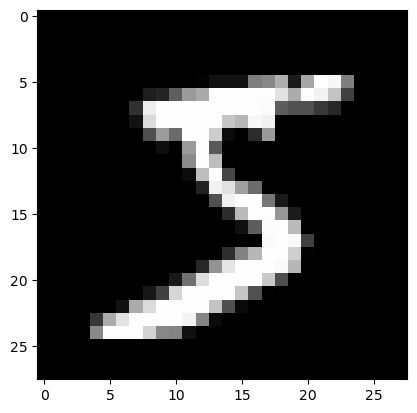

In [ ]:
## Displaying a MNIST Image

import matplotlib.pyplot as plt
import numpy as np

show_img = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

Label:
0


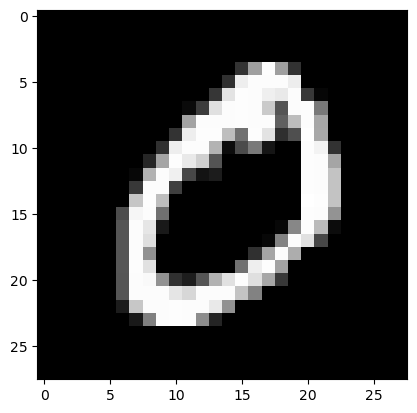

In [ ]:
## Displaying another MNIST Image
# Label
print("Label:")
print(train_dataset[1][1])

show_img = train_dataset[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

### Step #1 : Design your model using class


In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

###Step #2 : Construct loss and optimizer (select from PyTorch API)

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() `

It does 2 things at the same time.

1. Computes softmax ([Logistic or Sigmoid]/softmax function)
2. Computes Cross Entropy Loss


In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

###Step #3 : Training: forward, loss, backward, step


In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model.forward(images)

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:

                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model.forward(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.8646326065063477. Accuracy: 66.79
Iteration: 1000. Loss: 1.5964463949203491. Accuracy: 75.3
Iteration: 1500. Loss: 1.2992037534713745. Accuracy: 78.4
Iteration: 2000. Loss: 1.203499674797058. Accuracy: 80.39
Iteration: 2500. Loss: 1.0243752002716064. Accuracy: 81.62
Iteration: 3000. Loss: 1.0201406478881836. Accuracy: 82.43


[1.8646326065063477, 1.5964463949203491, 1.2992037534713745, 1.203499674797058, 1.0243752002716064, 1.0201406478881836]


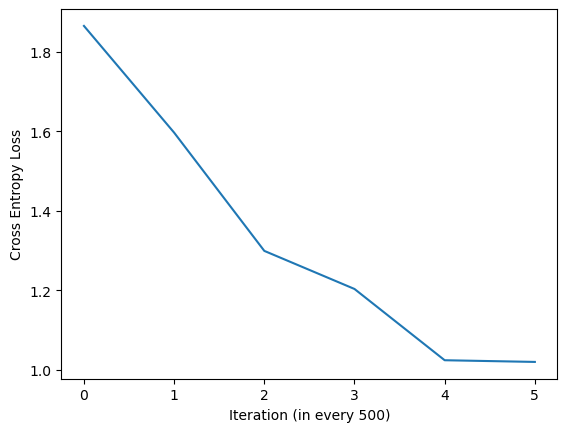

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/AUST Teaching Docs/AUST Fall 2019/Soft Computing/CSE 4238/Codes/05/'

### Save Model


In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'MNIST_logistic.pkl')

### Load Model


In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'MNIST_logistic.pkl'))
    print('Trained Model Loaded')

### Testing Loaded Model with Digits


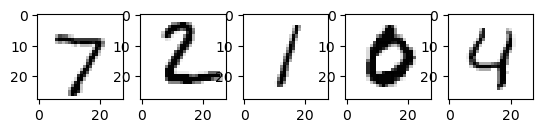

In [ ]:
for images, labels in test_loader:
    break

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [7 2 1 0 4]


## **NumtaDB: Bengali Handwritten Digits**

Dataset Link: https://www.kaggle.com/BengaliAI/numta/

**Snapshot from NumtaDB**

<div align="center">
<img src="https://drive.google.com/uc?id=1LvkNwV1My2RniR_JsbasBET1fa97eMQu" width="500">
</div>
